# Reporting dates vs incident dates
What happens if data is collected by reporting date instead of by incident date?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import pyplot as plt

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

def pltdflt(figsize=(12, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid(True, which="minor", linestyle="--")
    plt.grid(True, which="major", color="0.5")
    return fig, ax

# Expected report date usage impact

We expect that using report dates would show:

 - slower growth up to the peak
 - the peak later than it actually occurs
 - slower dropping off after the peak.Overestmate cases after the peak.
 
 We run tests on the normal PDF to demonstrate this.

In [3]:
from scipy import stats

In [4]:
x = np.linspace(-4, 4, 800)

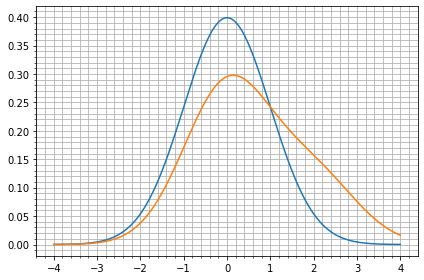

In [5]:
plt.plot(x, stats.norm.pdf(x))
plt.plot(x, stats.norm.pdf(x)*.7 + stats.norm.pdf(x-2)*.3)

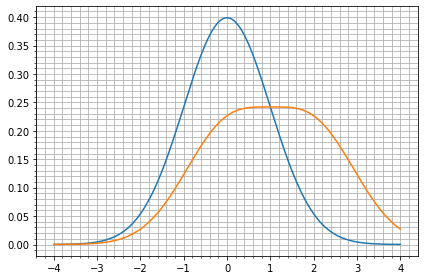

In [6]:
plt.plot(x, stats.norm.pdf(x))
plt.plot(x, stats.norm.pdf(x)*.5 + stats.norm.pdf(x-2)*.5)

# Load history
Full history is loaded into the `hdat` dataframe.

In [7]:
hdat = pd.read_csv("../history.csv")
hdat["DATE_OF_INTEREST"] = pd.to_datetime(hdat["DATE_OF_INTEREST"])
hdat["AS_OF"] = pd.to_datetime(hdat["AS_OF"])

In [8]:
hdat.head()

,DATE_OF_INTEREST,AS_OF,CASE_COUNT_7DAY_AVG,"Cases/day, 7 day avg",DEATH_COUNT,"Deaths/day, 7 day avg",HOSPITALIZED_CASE_COUNT,"Hospitalized/day, 7 day avg",INCOMPLETE,NEW_COVID_CASE_COUNT
0,2020-03-13,2020-03-26 11:26:41,NaN,603.000000,1.0,1.000000,123.0,123.000000,NaN,603.0
1,2020-03-14,2020-03-26 11:26:41,NaN,602.000000,2.0,1.500000,160.0,141.500000,NaN,601.0
2,2020-03-15,2020-03-26 11:26:41,NaN,726.333333,5.0,2.666667,193.0,158.666667,NaN,975.0
3,2020-03-16,2020-03-26 11:26:41,NaN,1023.000000,9.0,4.250000,290.0,191.500000,NaN,1913.0
4,2020-03-17,2020-03-26 11:26:41,NaN,1251.000000,7.0,4.800000,315.0,216.200000,NaN,2163.0


# Generate report time counts
We group by the date each report was received (the "AS_OF" date), and subtract from the previous report to get the new counts for each report.  Note that to get daily counts, we then also have to:

 - Aggregate counts when there's more than one report per day.
 - Add zero counts for dates on which there's no report.
 
 Results will be in the `rptdf` dataframe.

In [9]:
# Compute total counts for each report date
rptdf = hdat.groupby("AS_OF").sum()

# Compute new cases for each report date
rptdf["new_cases"] = rptdf["NEW_COVID_CASE_COUNT"].diff()
rptdf["new_deaths"] = rptdf["DEATH_COUNT"].diff()
rptdf["new_hospitalized"] = rptdf["HOSPITALIZED_CASE_COUNT"].diff()

# Fix counts for the case where there are multiple reports on a given date 
rptdf.reset_index(inplace=True)
rptdf.rename(columns={"AS_OF": "AS_OF_DT"}, inplace=True) # As of datetime
rptdf["AS_OF"] = rptdf["AS_OF_DT"].dt.date # Now just a date
rptdf["AS_OF"] = pd.to_datetime(rptdf["AS_OF"])
rptdf.set_index("AS_OF", inplace=True)
rptdf = rptdf.groupby("AS_OF").sum()

# Add in zero counts
dtl = pd.date_range(np.min(rptdf.index), np.max(rptdf.index))
dtldf = pd.DataFrame(dtl, columns=["AS_OF"])
rptdf = rptdf.merge(dtldf, how="outer", left_index=True, right_on=["AS_OF"]).sort_values("AS_OF")
rptdf.fillna(value=0, inplace=True)
rptdf.set_index("AS_OF", inplace=True)

# Calculate rolling window results
rptdf["Cases/day, 7 day avg"] = rptdf["new_cases"].rolling(window="7D").mean()
rptdf["Deaths/day, 7 day avg"] = rptdf["new_deaths"].rolling(window="7D").mean()
rptdf["Hospitalized/day, 7 day avg"] = rptdf["new_hospitalized"].rolling(window="7D").mean()

rptdf.head()

,CASE_COUNT_7DAY_AVG,"Cases/day, 7 day avg",DEATH_COUNT,"Deaths/day, 7 day avg",HOSPITALIZED_CASE_COUNT,"Hospitalized/day, 7 day avg",INCOMPLETE,NEW_COVID_CASE_COUNT,new_cases,new_deaths,new_hospitalized
AS_OF,,,,,,,,,,,
2020-03-26,0.0,0.000000,261.0,0.000000,3690.0,0.000000,0.0,19310.0,0.0,0.0,0.0
2020-03-27,0.0,3126.500000,812.0,93.500000,9168.0,529.000000,0.0,47544.0,6253.0,187.0,1058.0
2020-03-28,0.0,2084.333333,0.0,62.333333,0.0,352.666667,0.0,0.0,0.0,0.0,0.0
2020-03-29,0.0,1563.250000,0.0,46.750000,0.0,264.500000,0.0,0.0,0.0,0.0,0.0
2020-03-30,0.0,1250.600000,0.0,37.400000,0.0,211.600000,0.0,0.0,0.0,0.0,0.0


# Get latest report (for comparison)

In [10]:
latest = hdat[hdat["AS_OF"] == np.max(hdat["AS_OF"])]
latest.set_index("DATE_OF_INTEREST", inplace=True)

In [11]:
latest.head()

,AS_OF,CASE_COUNT_7DAY_AVG,"Cases/day, 7 day avg",DEATH_COUNT,"Deaths/day, 7 day avg",HOSPITALIZED_CASE_COUNT,"Hospitalized/day, 7 day avg",INCOMPLETE,NEW_COVID_CASE_COUNT
DATE_OF_INTEREST,,,,,,,,,
2020-09-16,2020-09-23 12:54:52,297.0,343.000000,7.0,7.000000,29.0,29.000000,6000.0,343.0
2020-09-17,2020-09-23 12:54:52,296.0,325.500000,2.0,4.500000,27.0,28.000000,6000.0,308.0
2020-09-18,2020-09-23 12:54:52,291.0,300.666667,4.0,4.333333,23.0,26.333333,6000.0,251.0
2020-09-19,2020-09-23 12:54:52,281.0,254.500000,1.0,3.500000,18.0,24.250000,6000.0,116.0
2020-09-20,2020-09-23 12:54:52,260.0,223.600000,0.0,2.800000,9.0,21.200000,6000.0,100.0


# Plot results
Compare cases/day and 7 day averages of cases/day

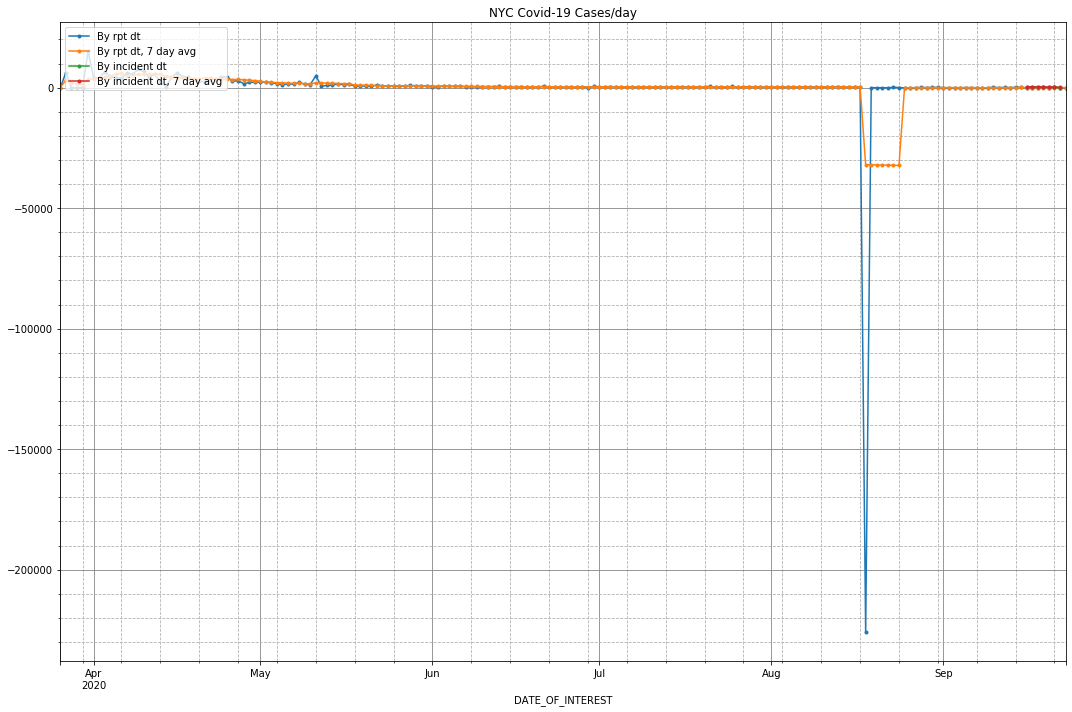

In [12]:
fig, ax = pltdflt((15,10))
rptdf[["new_cases", "Cases/day, 7 day avg"]].plot(style=".-", ax=ax)

latest[["NEW_COVID_CASE_COUNT", "Cases/day, 7 day avg"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt", "By rpt dt, 7 day avg", "By incident dt", "By incident dt, 7 day avg"], loc="upper left")
plt.title("NYC Covid-19 Cases/day")
plt.savefig("casesPerDayHistoryRptDtVsInDt.png")

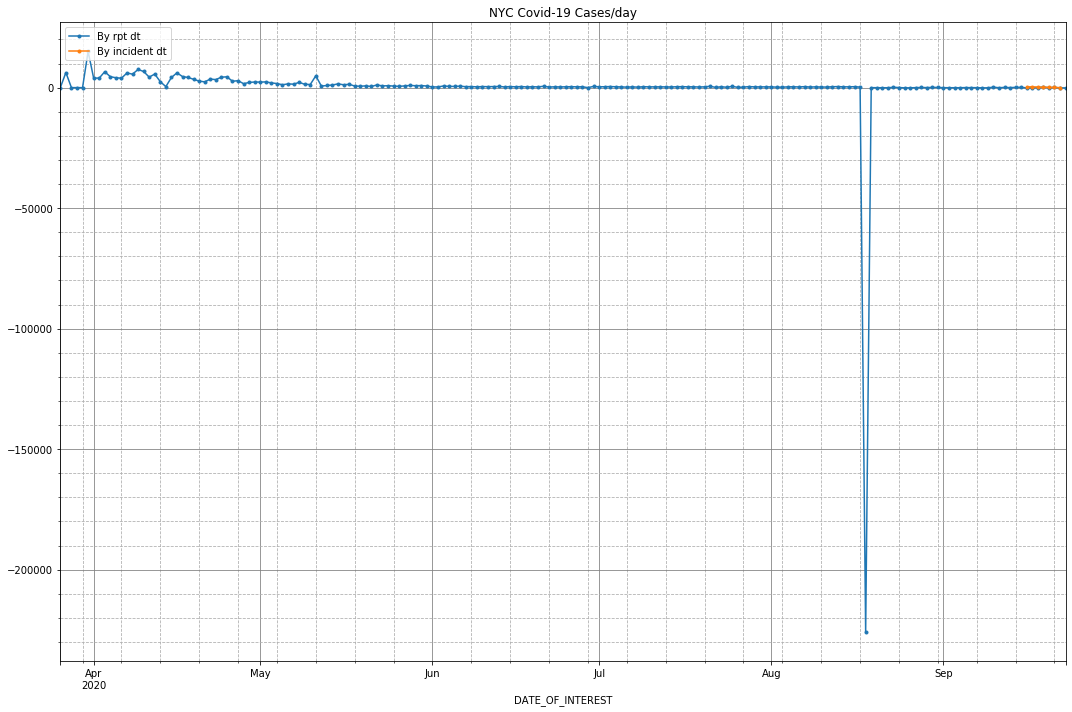

In [13]:
fig, ax = pltdflt((15,10))
rptdf[["new_cases"]].plot(style=".-", ax=ax)

latest[["NEW_COVID_CASE_COUNT"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt", "By incident dt"], loc="upper left")
plt.title("NYC Covid-19 Cases/day")
plt.savefig("casesPerDayHistoryRptDtVsInDtRaw.png")

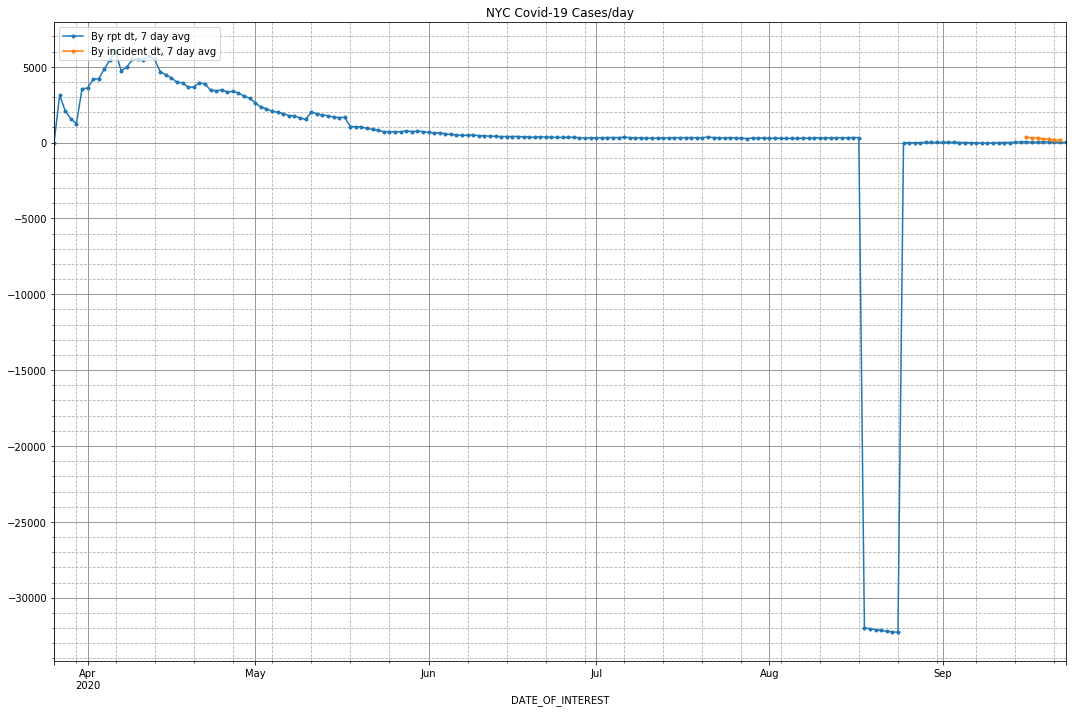

In [14]:
fig, ax = pltdflt((15,10))
rptdf[["Cases/day, 7 day avg"]].plot(style=".-", ax=ax)

latest[["Cases/day, 7 day avg"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt, 7 day avg", "By incident dt, 7 day avg"], loc="upper left")
plt.title("NYC Covid-19 Cases/day")
plt.savefig("casesPerDayHistoryRptDtVsInDt.png")

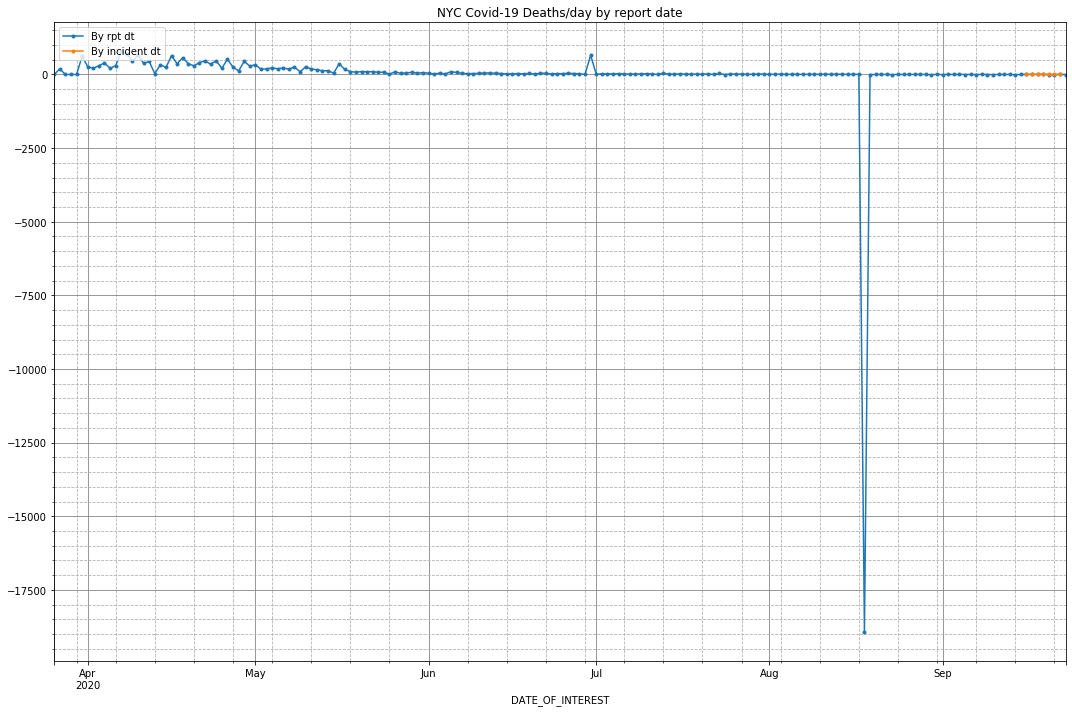

In [15]:
fig, ax = pltdflt((15,10))
rptdf[["new_deaths"]].plot(style=".-", ax=ax)

latest[["DEATH_COUNT"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt", "By incident dt"], loc="upper left")
plt.title("NYC Covid-19 Deaths/day by report date")
plt.savefig("deathsPerDayHistoryRptDtVsInDtRaw.png")

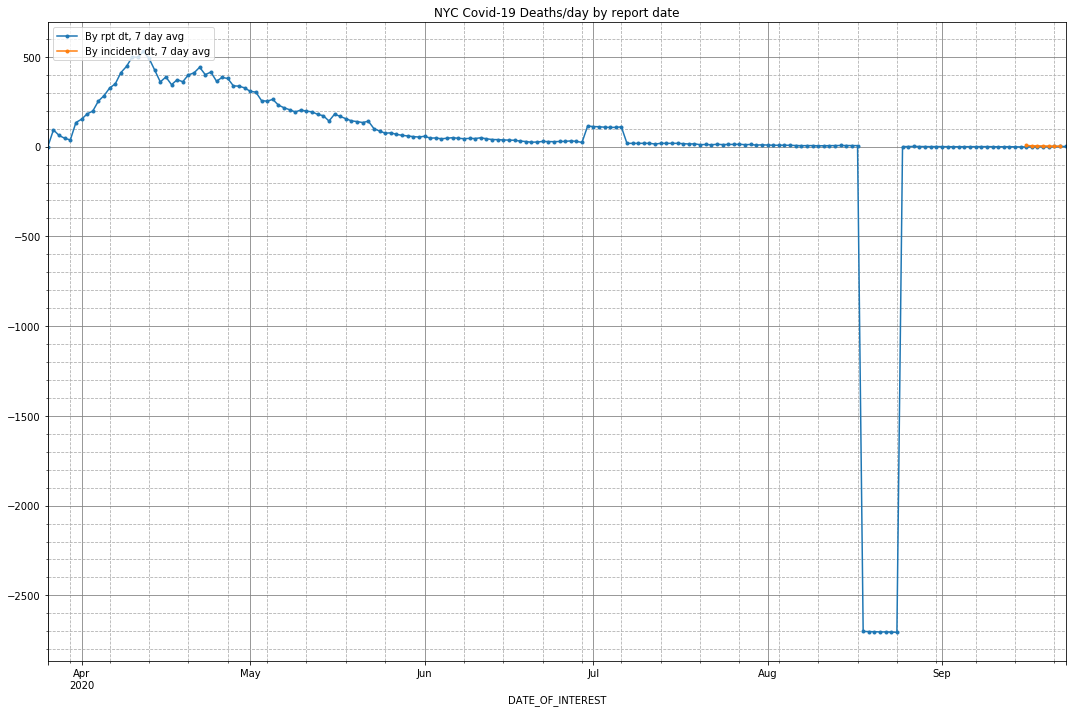

In [16]:
fig, ax = pltdflt((15,10))
rptdf[["Deaths/day, 7 day avg"]].plot(style=".-", ax=ax)

latest[["Deaths/day, 7 day avg"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt, 7 day avg", "By incident dt, 7 day avg"], loc="upper left")
plt.title("NYC Covid-19 Deaths/day by report date")
plt.savefig("deathsPerDayHistoryRptDtVsInDt.png")

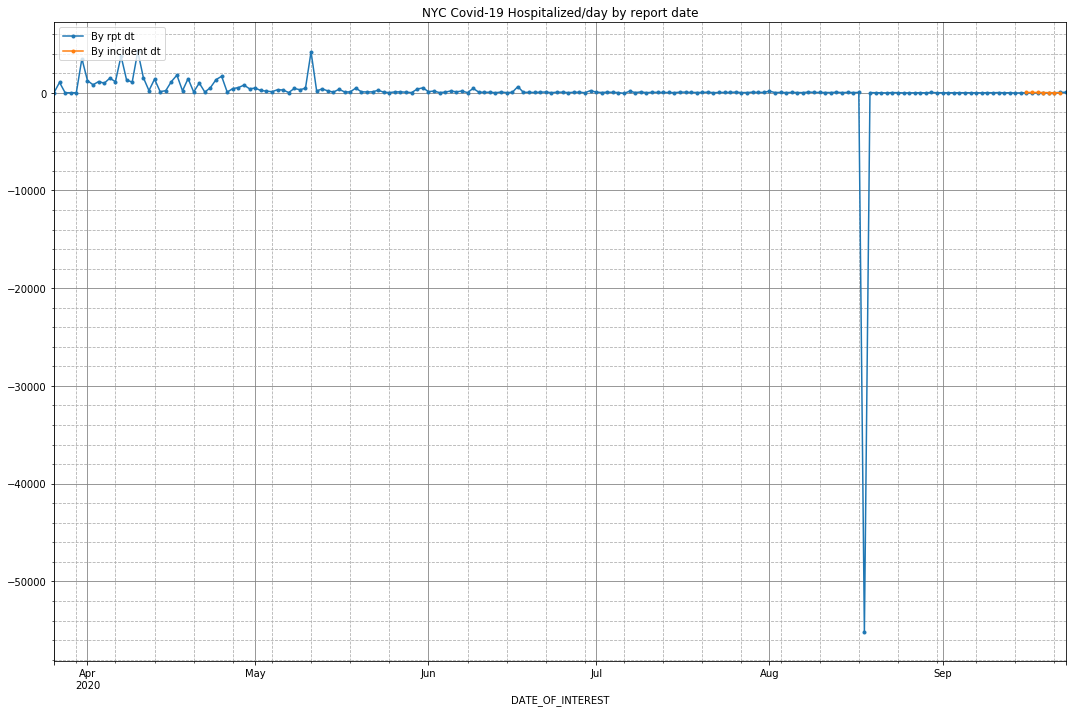

In [17]:
fig, ax = pltdflt((15,10))
rptdf[["new_hospitalized"]].plot(style=".-", ax=ax)

latest[["HOSPITALIZED_CASE_COUNT"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt", "By incident dt"], loc="upper left")
plt.title("NYC Covid-19 Hospitalized/day by report date")
plt.savefig("hospitalizedPerDayHistoryRptDtVsInDtRaw.png")

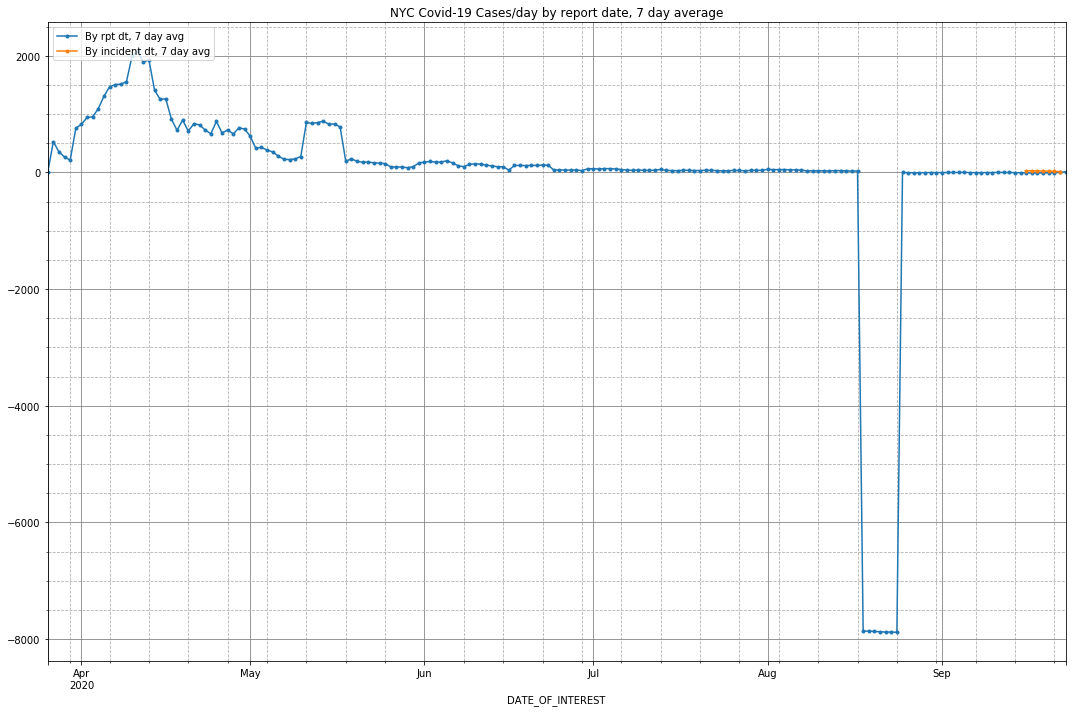

In [18]:
fig, ax = pltdflt((15,10))
rptdf[["Hospitalized/day, 7 day avg"]].plot(style=".-", ax=ax)

latest[["Hospitalized/day, 7 day avg"]].plot(style=".-", ax=ax)

ax.legend(["By rpt dt, 7 day avg", "By incident dt, 7 day avg"], loc="upper left")
plt.title("NYC Covid-19 Cases/day by report date, 7 day average")
plt.savefig("hospitalizedPerDayHistoryRptDtVsInDt.png")

# Observations
We see that in this case, recording by report date

 - injects substantial noise
 - destroys periodicity - 7 day averages still show substantial noise
 - peak is harder to identify
 - post-peak numbers are substantially higher
 - ramp up to peak appears to be much faster than it actually is (in the 7 day average data)
 - peak appears to be higher than actual
 
Everything is as expected, except for the last two points. We expected a slower ramp-up, and a lower peak.  Possibly the reporting delay isn't stationary - there's more delay in collecting data early on, so the ramp up is due to the delay shortening and the data is piling up around the peak, causing the peak to be higher.